<a href="https://colab.research.google.com/github/shahrazzkhmohammed/learn-python/blob/master/FBProphet_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anomaly detection using Facebook Prophet :
Anomaly detection identifies data points or observations that deviate from a datasets normal behavior.

The anomaly data can indicate critical incident in the business or also a potential opportunity that could be advantagious to the business.

Anomaly detection can be used in fraud detection, identifying product quality issues in manufacturing.

There are two types of anomaly detection.

Global outlier - It exists far outside the entire dataset i.e. completely outside the normal distribution of data. It can be due to data issues or business process issues. It can also be genuine data element that the regular analysis generated.

Contextual outliers are very common in time series data. These values exists within the global expectations but may appear anomalous for certain seasonal data pattern.

In [ ]:
# Matplotlib library is used for data visualization 
# Numpy and Pandas library are for data wrangling and preprocessing. 
# Plotly express library allows to zoom into a particular datapoint in visualizer.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
# South Korea Bike Data set from UCI Machine Learning repository is used in this Assignment. 
# It is a time series dataset that includes number of bikes rented each hour daily on yearly basis.
# https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
from google.colab import files
uploaded = files.upload()

Saving SeoulBikeData.csv to SeoulBikeData (1).csv


In [ ]:
# Assigning the dataset to the dataframe df
# Unicode escape produces a string that is suitable as Unicode literal in Python source code

df = pd.read_csv('SeoulBikeData.csv',encoding = 'unicode_escape')

In [ ]:
# The dataset has 8760 rows and 14 columns.
# The observations are for every hour. The Primary columns in the dataset are Date, Rented Bike Count and Hour.
# The Date and Hour columns are merged to create a DateTime column.
df

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
df['Hour'] = pd.to_datetime(df['Hour'], unit='h')

In [ ]:
df['Hour']= df['Hour'].dt.time

In [ ]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,00:00:00,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,01:00:00,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,02:00:00,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,03:00:00,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,04:00:00,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
df['Date'] = df['Date'].map(str) + ' ' + df['Hour'].map(str)

In [ ]:
df['Date'] = pd.to_datetime(df['Date']) 

In [ ]:
# After merging the date and hour columns, all irrelevant columns from the dataset are removed. 
# The dataframe now has only two columns Date and Rented BIke Count.
df = df.iloc[:,0:2]

In [ ]:
df.head()

,Date,Rented Bike Count
0,2017-01-12 00:00:00,254
1,2017-01-12 01:00:00,204
2,2017-01-12 02:00:00,173
3,2017-01-12 03:00:00,107
4,2017-01-12 04:00:00,78


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8760 non-null   datetime64[ns]
 1   Rented Bike Count  8760 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 137.0 KB


In [ ]:
# Aggregating the data on hourly basis
df = df.set_index('Date').resample("H").mean()

In [ ]:
df = df.fillna(0)

In [ ]:
# Drawing a line chart, the reset index will take out the index. 
# In x - axis the 'Date' column is passed and in y-axis the 'Rented Bike Count' column

fig = px.line(df.reset_index(), x='Date', y='Rented Bike Count', title='Seoul Bike Data')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()

The line graph shows data from Jan 2017 to Dec 2018. The spikes show high number of rented bikes and lines close to the margin show low number of rented bikes.

In [ ]:
# Importing the Prophet package from fbprophet
from fbprophet import Prophet

In [ ]:
# Renaming the columns to 'ds' and 'y' as this is an important requirement in fbprophet.
df = df.reset_index()[['Date', 'Rented Bike Count']].rename({'Date':'ds', 
                                                           'Rented Bike Count':'y'}, 
                                                          axis='columns')

In [ ]:
train = df[(df['ds']>='2017-01-12')&(df['ds']<='2018-09-30')]
test = df[(df['ds']>'2018-09-30')]

In [ ]:
print(train.shape)
print(test.shape)

(15025, 2)
(1751, 2)


In [ ]:
df.head()
df.tail(200)

,ds,y
16576,2018-12-03 16:00:00,752.0
16577,2018-12-03 17:00:00,931.0
16578,2018-12-03 18:00:00,1425.0
16579,2018-12-03 19:00:00,946.0
16580,2018-12-03 20:00:00,801.0
...,...,...
16771,2018-12-11 19:00:00,1466.0
16772,2018-12-11 20:00:00,1292.0
16773,2018-12-11 21:00:00,1189.0
16774,2018-12-11 22:00:00,1023.0


In [ ]:
# By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. 
# This default works in many situations but not all, and can be changed using the changepoint_range argument. 
# For example, m = Prophet(changepoint_range=0.9) in Python will place potential changepoints in the first 90% of the time series.
model = Prophet(changepoint_range= 0.95)

In [ ]:
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# Create a future dataframe to predict on the data, by default the method creates a daily frequency. 
# "H" is passed in the method to create hourly frequency.
future = model.make_future_dataframe(periods=1751,freq= 'H')

future

,ds
0,2017-01-12 00:00:00
1,2017-01-12 01:00:00
2,2017-01-12 02:00:00
3,2017-01-12 03:00:00
4,2017-01-12 04:00:00
...,...
16771,2018-12-11 19:00:00
16772,2018-12-11 20:00:00
16773,2018-12-11 21:00:00
16774,2018-12-11 22:00:00


In [ ]:
# Predicting the Rented bike count for future dates.
# Calling the predict function on the model using the future dataframe and assigning it to a forecast variable.
forecast = model.predict(future)

In [ ]:
# yhat is the predicted value,yhat_lower and yhat_upper are the limits
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
16771,2018-12-11 19:00:00,733.916903,240.432895,1255.605975
16772,2018-12-11 20:00:00,688.484487,163.963855,1207.000099
16773,2018-12-11 21:00:00,599.734738,82.795536,1113.273328
16774,2018-12-11 22:00:00,510.566229,9.245018,1001.177109
16775,2018-12-11 23:00:00,449.510987,-37.496705,1012.843702


In [ ]:
# Creating a new result dataframe by using index based concatination of the forecast and df dataframes to compare the y actual and y predict.
results = pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')[['yhat','yhat_lower', 'yhat_upper']]],
                    axis=1)

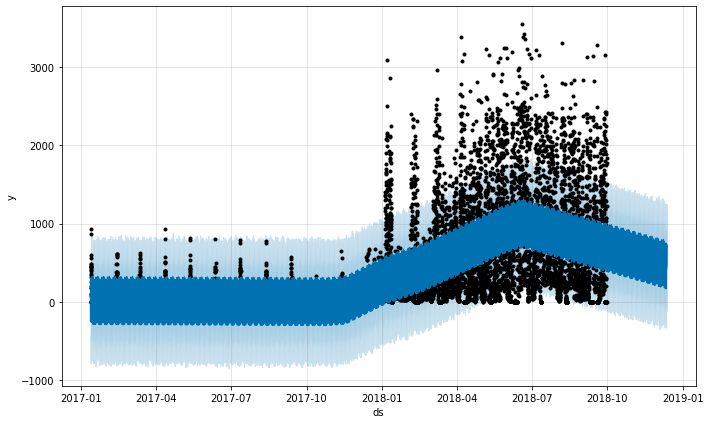

In [ ]:
# plotting the forecast 
# The black dots represents the actual vlaues and the blue area represent y-predicted
fig1 = model.plot(forecast)

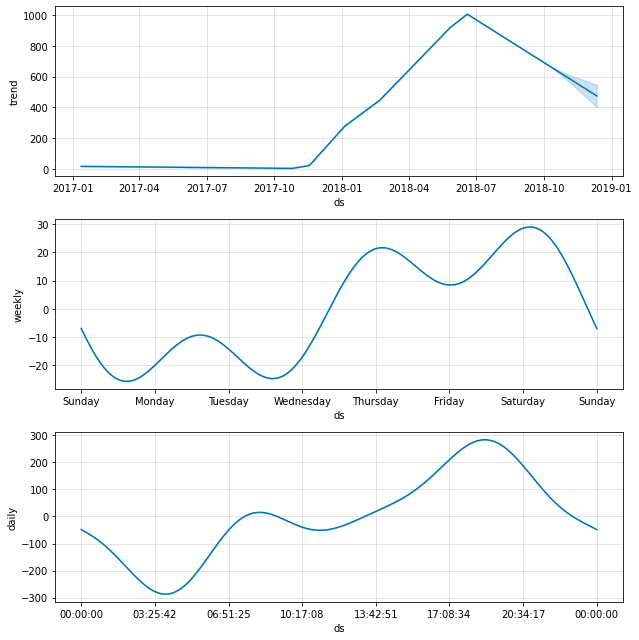

In [ ]:
# Plotting the components of the forecast dataframe to see the trend and seasonality.
comp = model.plot_components(forecast)

The first 6 months of 2018 had a increasing trend of rented bike count and it slowly started decreasing from the seventh month of 2018

Bikes mostly rented on Thrusdays or on the Saturdays

Bike renting drops after midnight and it rises after 4:00 am in the morning. There a slight drop in bikes renting around 10:00 am but the bike renting starts increasing after 10:30 am and keeps on increasing till 7:00 pm at night



In [ ]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2017-01-12 00:00:00,254.0,-10.392251,-537.424456,479.906105
2017-01-12 01:00:00,204.0,-62.677673,-563.640141,435.375184
2017-01-12 02:00:00,173.0,-139.930316,-668.606091,360.468846
2017-01-12 03:00:00,107.0,-217.803113,-784.938502,279.971117
2017-01-12 04:00:00,78.0,-248.655189,-775.529427,246.485074


In [ ]:
# Error is the difference between the actual and predicted values, it is also called as residual.
results['error'] = results['y'] - results['yhat'] 

In [ ]:
# Uncertainty is the difference between the upper and lower predicted values.
results['uncertainity'] = results['yhat_upper'] - results['yhat_lower']

In [ ]:
# Finding the outliers by comparing 1.5 times of the uncertainty with absolute value of error; any value inplace of 1.5 can be used.
# The value 1.5 is just a threshold. 
results[results['error'].abs()> 1.5*results['uncertainity']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainity
ds,,,,,,
2018-01-05 18:00:00,2082.0,570.734643,94.162088,1085.144734,1511.265357,990.982646
2018-01-06 08:00:00,2149.0,323.179252,-158.875647,824.137472,1825.820748,983.013120
2018-01-06 17:00:00,2123.0,495.396764,19.917580,984.513856,1627.603236,964.596276
2018-01-06 18:00:00,3088.0,557.783750,91.743629,1087.800531,2530.216250,996.056902
2018-01-06 19:00:00,2505.0,573.522858,36.572844,1063.042569,1931.477142,1026.469725
...,...,...,...,...,...,...
2018-12-09 08:00:00,2391.0,473.117504,-66.632189,1011.506109,1917.882496,1078.138298
2018-12-09 18:00:00,3256.0,720.183521,211.556976,1214.397603,2535.816479,1002.840627
2018-12-09 19:00:00,2443.0,738.598246,210.456283,1247.531816,1704.401754,1037.075533


In [ ]:
# Creating a new categorical column called anomaly based on error and uncertainty using lambda function.
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error'])>1.5*x['uncertainity']) else 'No',axis=1)

In [ ]:
results.tail(5)

,y,yhat,yhat_lower,yhat_upper,error,uncertainity,anomaly
ds,,,,,,,
2018-12-11 19:00:00,1466.0,733.916903,240.432895,1255.605975,732.083097,1015.173081,No
2018-12-11 20:00:00,1292.0,688.484487,163.963855,1207.000099,603.515513,1043.036244,No
2018-12-11 21:00:00,1189.0,599.734738,82.795536,1113.273328,589.265262,1030.477792,No
2018-12-11 22:00:00,1023.0,510.566229,9.245018,1001.177109,512.433771,991.932091,No
2018-12-11 23:00:00,702.0,449.510987,-37.496705,1012.843702,252.489013,1050.340407,No


In [ ]:
# Time series graph with different color for anomaly data points.
fig = px.scatter(results.reset_index(), x='ds', y='y', 
                 color='anomaly',title='Seoul Bike Data')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                     dict(count=1, label='1y', step='year', stepmode='backward'),
                     dict(count=2, label='3y', step='year', stepmode='backward'),
                     dict(count=3, label='5y', step='year', stepmode='backward'),
                     dict(step='all')
        ])
    )
)
fig.show()



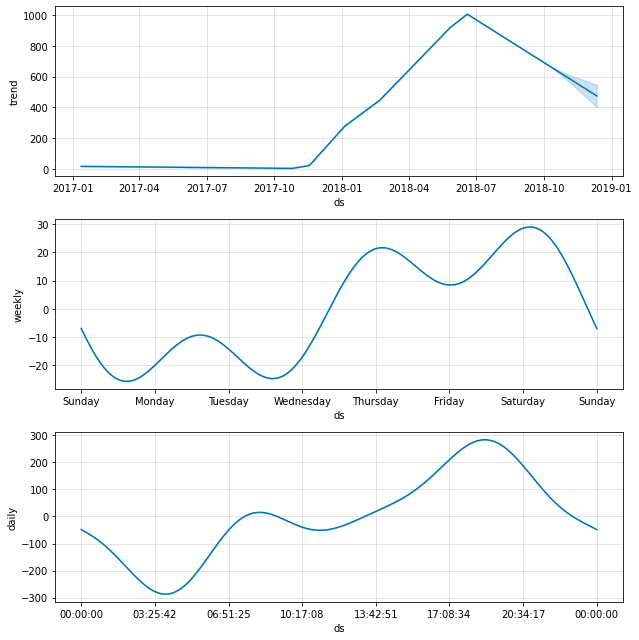

In [ ]:
comp = model.plot_components(forecast)

In [ ]:
# calculate Mean Absolute Error and Mean Squared Error between expected and predicted values
y_true = results['y'].values
y_pred = results['yhat'].values




In [ ]:
y_true = pd.DataFrame(data = y_true,index= None)

In [ ]:
y_pred = pd.DataFrame(data = y_pred,index= None)

In [ ]:

y_true = y_true.rename(columns={0: 'y'})

In [ ]:
y_pred = y_pred.rename(columns={0: 'yhat'})

In [ ]:
y_true = y_true.fillna(0)

In [ ]:
y_pred = y_pred.fillna(0)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
mae = mean_absolute_error(y_true, y_pred,multioutput='raw_values')
print('MAE: %.3f' % mae)

MAE: 280.177


In [ ]:
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)

MSE: 174252.879


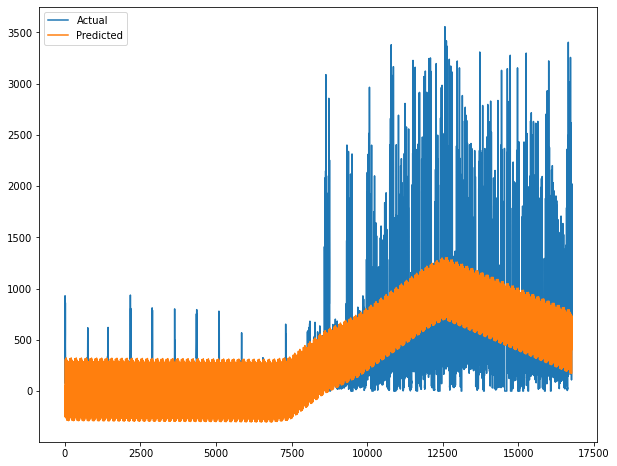

In [ ]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Storing the forecast dataframe as a csv file in Google drive.
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
forecast.to_csv('/content/drive/My Drive/My data files/FBAnomaly.csv')

Mounted at /content/drive/
